# 한 눈에 보는 머신러닝

**감사의 글**

오렐리앙 제롱<font size='2'>Aurélien Géron</font>의 [Hands-On Machine Learning with Scikit-Learn and PyTorch (O'Reilly, 2025)](https://github.com/ageron/handson-mlp)에 사용된 코드를 참고한 강의노트입니다. 자료를 공개한 오렐리앙 제롱과 일부 그림 자료를 제공해 준 한빛아카데미에게 진심어린 감사를 전합니다.

## 환경설정

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

It also requires Scikit-Learn ≥ 1.6.1:

In [2]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

Let's define the default font sizes, to plot pretty figures:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

**기본 라이브러리**

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 삶의 만족도 예측

### 데이터셋 다운로드

In [5]:
# Download and prepare the data
data_root = "https://github.com/codingalzi/code-workout-ml/raw/master/notebooks/datasets/"

lifesat_full = pd.read_csv(data_root + "lifesat/lifesat_full.csv")

In [6]:
lifesat_full.set_index("Country", inplace=True)

2020년도 기준 37개 OECD 회원국과 함께 3개 국가가 추가된 총 40개 국가의 데이터로 구성된 데이터프레임이 생성된었음.

In [7]:
lifesat_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, South Africa to Luxembourg
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GDP per capita (USD)  40 non-null     float64
 1   Life satisfaction     40 non-null     float64
dtypes: float64(2)
memory usage: 960.0+ bytes


In [8]:
lifesat_full

,GDP per capita (USD),Life satisfaction
Country,,
South Africa,11466.189672,4.7
Colombia,13441.492952,6.3
Brazil,14063.982505,6.4
Mexico,17887.750736,6.5
Chile,23324.524751,6.5
Russia,26456.387938,5.8
Greece,27287.083401,5.4
Turkey,28384.987785,5.5
Latvia,29932.493910,5.9


**부분 데이터셋 지정**

- 과대적합 현상 등을 설명하기 위해 먼저 일부 데이터만 사용함
- 먼저 1인당 GDP가 23,500 달러 ~ 62,500 달러 사이의 국가만 선택

In [9]:
gdppc_col = "GDP per capita (USD)"
lifesat_col = "Life satisfaction"

min_gdp = 23_500
max_gdp = 62_500

lifesat = lifesat_full[(lifesat_full[gdppc_col] >= min_gdp) &
                                   (lifesat_full[gdppc_col] <= max_gdp)]

9개 국가가 제외된 총 31개 국가만 선택됨.

In [10]:
lifesat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, Russia to United States
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GDP per capita (USD)  31 non-null     float64
 1   Life satisfaction     31 non-null     float64
dtypes: float64(2)
memory usage: 744.0+ bytes


제외된 9개 국가 명단

In [11]:
set(lifesat_full.index) - set(lifesat.index)

{'Brazil',
 'Chile',
 'Colombia',
 'Ireland',
 'Luxembourg',
 'Mexico',
 'Norway',
 'South Africa',
 'Switzerland'}

**선택된 31개 국가 산점도**

- x축: 1인당 GDP
- y축: 삶의 만족도
- 한국 포함 7개 국가 별도 표기. 

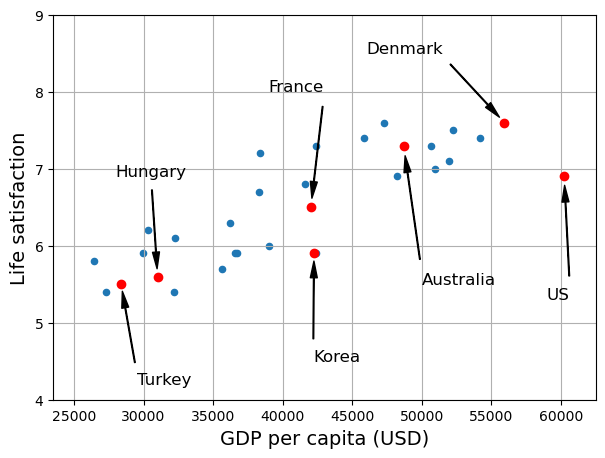

In [12]:
lifesat.plot(kind='scatter', figsize=(7, 5), grid=True, x=gdppc_col, y=lifesat_col)

position_text = {
    "Turkey": (29_500, 4.2),
    "Hungary": (28_000, 6.9),
    "France": (39_000, 8.0),
    "South Korea": (42_200, 4.5),
    "Australia": (50_000, 5.5),
    "United States": (59_000, 5.3),
    "Denmark": (46_000, 8.5)
}

for country, pos_text in position_text.items():
    pos_data_x = lifesat[gdppc_col].loc[country]
    pos_data_y = lifesat[lifesat_col].loc[country]

    # 미국과 한국 단축명 활용
    if country == "United States":
        country = "US"
    elif  country == "South Korea":
        country = "Korea"
        
    plt.annotate(country, xy=(pos_data_x, pos_data_y),
                 xytext=pos_text, fontsize=12,
                 arrowprops=dict(facecolor='black', width=0.5,
                                 shrink=0.08, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")


# Set the axis limits
min_life_sat = 4
max_life_sat = 9
plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

plt.show()

선택된 7개 국가 데이터

In [13]:
highlighted_countries = lifesat.loc[list(position_text.keys())]
highlighted_countries[[gdppc_col, lifesat_col]].sort_values(by=gdppc_col)

,GDP per capita (USD),Life satisfaction
Country,,
Turkey,28384.987785,5.5
Hungary,31007.768407,5.6
France,42025.617373,6.5
South Korea,42251.445057,5.9
Australia,48697.837028,7.3
Denmark,55938.212809,7.6
United States,60235.728492,6.9


적절하지 않은 세 개의 선형 회귀 모델

- 세 직선의 기울기와 절편은 사람이 수동으로 적절하지 않은 선형 회귀 모델을 시각화하기 위해 임의로 선택됨.

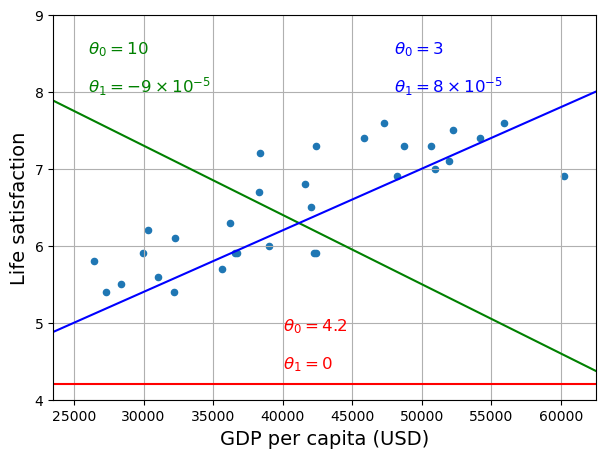

In [14]:
lifesat.plot(kind='scatter', figsize=(7, 5), grid=True, x=gdppc_col, y=lifesat_col)

X_range = np.linspace(min_gdp, max_gdp, 1000)

w1, w2 = 4.2, 0
plt.plot(X_range, w1 + w2 * 1e-5 * X_range, "r")
plt.text(40_000, 4.9, fr"$\theta_0 = {w1}$", color="r")
plt.text(40_000, 4.4, fr"$\theta_1 = {w2}$", color="r")

w1, w2 = 10, -9
plt.plot(X_range, w1 + w2 * 1e-5 * X_range, "g")
plt.text(26_000, 8.5, fr"$\theta_0 = {w1}$", color="g")
plt.text(26_000, 8.0, fr"$\theta_1 = {w2} \times 10^{{-5}}$", color="g")

w1, w2 = 3, 8
plt.plot(X_range, w1 + w2 * 1e-5 * X_range, "b")
plt.text(48_000, 8.5, fr"$\theta_0 = {w1}$", color="b")
plt.text(48_000, 8.0, fr"$\theta_1 = {w2} \times 10^{{-5}}$", color="b")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

plt.show()

### 선형회귀 예측

머신러닝 회귀 모델을 지도 학습 방식으로 학습시키려면 훈련셋과 타깃셋이 
일반적으로 넘파이 어레이로 먼저 지정되어야 한다.

- 훈련셋: 31개 국가의 1인당 GDP
- 타깃셋: 31개 국가의 삶의 만족도

**훈련셋**

In [15]:
X = lifesat[["GDP per capita (USD)"]].values

**타깃셋**

In [16]:
y = lifesat[["Life satisfaction"]].values

**선형 회귀 모델 지정**

절편 $\theta_0$와 기울기 $\theta_1$이 무작위로 선택되어 초기화된
선형 회귀 모델을 지정하여 학습을 준비한다.
이를 위해 사이킷런 라이브러리를 다음과 같이 활용한다.

- `LinearRegression`은 `sklearn` 라이브러리에 포함된 `linear_model` 모듈에서 정의된 클래스

In [17]:
from sklearn.linear_model import LinearRegression

- 선형 회귀 모델 지정: `LinearRegression` 클래스의 객체 생성

In [18]:
# Select a linear model
oecd_linear_model = LinearRegression()

**선형 회귀 모델 학습**

- 훈련셋과 타깃셋을 이용한 지정된 선형 회귀 모델 학습
- `fit()` 메서드에 훈련셋과 타깃셋을 인자로 지정하여 호출

In [19]:
# Train the model
oecd_linear_model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


- `fit()` 메서드의 반환값은 없음.
- 학습이 완료된 모델 객체 자체에 저장된 속성(정보)이 달라짐.
- 예를 들어, 최적의 절편 $\theta_0$와 기울기 $\theta_1$이 모델 내부에 저장됨.

In [20]:
theta_0, theta_1 = oecd_linear_model.intercept_[0], oecd_linear_model.coef_[0][0]

print(f"theta_0: {theta_0:.2f}")
print(f"theta_1: {theta_1:.2e}")

theta_0: 3.84
theta_1: 6.51e-05


**학습된 모델 활용**

`oecd_linear_model`은 한 국가의 1인당 GDP가 주어졌을 때
해당 국가 국민의 삶의 만족도를 예측하도록 학습되었다.
학습된 모델을 이용한 예측은 모델 객체의 `predict()` 메서드를 활용한다.

모델을 활용한 예측은 학습할 때 사용된 데이터에 한정되지 않는다.
예를 들어, 아래 코드는 1인당 GDP가 33,422.8 달러인 국가의 국민들의 삶의 만족도는
6.0 정도로 예측된다.
참고로, 33,422.8 달러는 2020년 기준 푸에르토리코의 1인당 GDP이며,
푸에르토리코는 훈련셋에 포함되어 있지 않다.

- `X_new` 변수: `predict()` 메서드의 인자. 2차원 어레이.

In [21]:
# Make a prediction for Puerto Rico
puerto_rico_gdp_per_capita = 33_442.8  # Puerto Rico' GDP per capita in 2020
X_new = [[puerto_rico_gdp_per_capita]]

puerto_rico_predicted_life_satisfaction = oecd_linear_model.predict(X_new)[0][0]
print(f"푸에르토리코의 2020년 삶의 만족도 예측값: {puerto_rico_predicted_life_satisfaction:.2f}")

푸에르토리코의 2020년 삶의 만족도 예측값: 6.01


모델 학습으로 정해진 절편과 기울기를 사용하는 1차 함수 $f(x) = \theta_0 + \theta_1 \cdot x$를 이용하여
$f(x)$를 계산해도 동일한 결과가 나온다.

In [22]:
def f(x):
    return theta_0 + theta_1 * x

f(puerto_rico_gdp_per_capita)

np.float64(6.014985924721082)

**`predict()` 메서드의 인자와 반환값**

학습된 모델의 `predict()` 메서드의 인자는 일반적으로 2차원 어레이로 지정하며,
예측값 또한 2차원 어레이로 반환된다. 

먼저, 2차원 어레이 입력값의 내부에 포함된 1차원 어레이는 모델이 예측할 때 필요한 모든 데이터를 담아야 한다.
`oecd_linear_model`이 한 국가의 삶의 만족도를 예측하기 위해 필요한 정보는 해당 국가의
1인당 GDP 데이터 하나 뿐이다.
따라서 푸에르토리코의 삶의 만족도 예측에 필요한 `[33442.8]` 모양의 1차원 어레이다.

그런데 2차원 어레이를 입력값으로 지정하는 이유는 예를 들어 하나의 국가에 대해서만이 아니라 여러 나라의 삶의 만족도를
동시에 예측하기 위해 여러 나라의 1인당 GDP 정보를 인자로 받아야 하기 때문이다.
각 나라의 입력 정보가 1차원 어레이이기에 여러 나라의 입력정보는 2차원 어레이로 처리된다.

예를 들어, 아래 코드에서 `predict()` 메서드는 한국의 1인당 GDP와 일본의 1인당 GDP 를 포함한 두 개의 1차원 어레이로 구성된
2차원 어레이를 인자로 사용하며,
두 나라의 삶의 만족도로 구성된 1차원 어레이 두 개를 항목으로 갖는 2차원 어레이를 반환한다.

In [23]:
korea_gdp = lifesat_full.loc["South Korea", gdppc_col]
japan_gdp = lifesat_full.loc["Japan", gdppc_col]

print(f"한국 1인당 GDP: {korea_gdp:.2f}")
print(f"일본 1인당 GDP: {japan_gdp}")

print()

print('한국과 일본의 2020년 삶의 만족도 예측값:')
korea_japan_life_satisfaction = oecd_linear_model.predict([[korea_gdp], [japan_gdp]])
print(korea_japan_life_satisfaction)

한국 1인당 GDP: 42251.45
일본 1인당 GDP: 42390.4450571656

한국과 일본의 2020년 삶의 만족도 예측값:
[[6.58802774]
 [6.59707032]]


반환값이 2차원 어레이인 이유는 인자에 대한 이유와 유사한데,
머신러닝 모델이 하나의 입력값에 대해 여러 종류의 예측값을 동시에 예측할 수 있도록 학습될 수 있기 때문이다.
여기서는 삶의 만족도 한 종류의 값만 예측하도록 학습되었기에 각 국가별 예측값이 `[삶의 만족도]` 모양의 1차원 어레이다.

만약에 국가별 삶의 만족도 이외에, 예를 들어, 삶의 불만족도 또한 예측하도록 모델을 학습시켰다면
국가별 예측값은 `[삶의 만족도, 삶의 불만족도]` 모양의 길이가 2인 1차원 어레이가 되었을 것이다.

**선형 회귀 예측 그래프**

모델이 찾아낸 절편과 기울기를 갖는 직선의 그래프를 데이터 산점도와 함께
그리면 모델이 찾아낸 1인당 GDP와 삶의 만족도 사이의 선형 관계가 매우 적절함을 눈으로 확인할 수 있다.
선형 회귀 모델이 데이터 학습을 통해 어떻게 적절한 절편과 기울기를 학습하는지,
또 그렇게 학습된 절편과 기울기가 최선인지 여부를 어떻게 판단하는지에 대해서는
앞으로 자세히 다룰 예정이다.

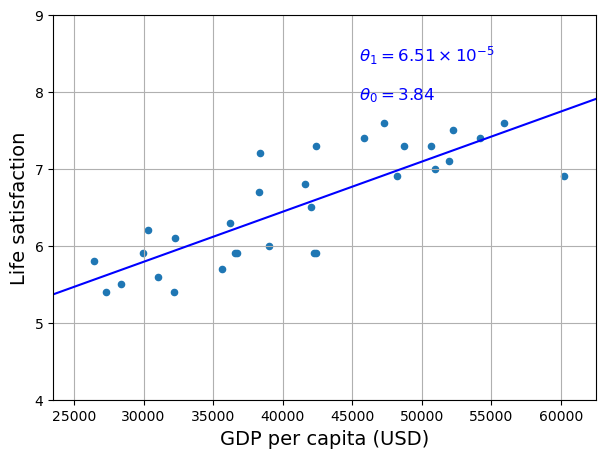

In [24]:
lifesat.plot(kind='scatter', figsize=(7, 5), grid=True, x=gdppc_col, y=lifesat_col)

X_range = np.linspace(min_gdp, max_gdp, 1000)
plt.plot(X_range, theta_0 + theta_1 * X_range, "b")

plt.text(min_gdp + 22_000, max_life_sat - 1.1,
         fr"$\theta_0 = {theta_0:.2f}$", color="b")
plt.text(min_gdp + 22_000, max_life_sat - 0.6,
         fr"$\theta_1 = {theta_1 * 1e5:.2f} \times 10^{{-5}}$", color="b")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])
plt.show()

아래 코드는 산점도, 선형 회귀 예측 그래프와 더불어 모델의 학습에 사용되지 않은
푸에로코리코의 1인당 GDP에 대해 학습된 모델이 예측한 삶의 만족도를 함께 보여준다. 

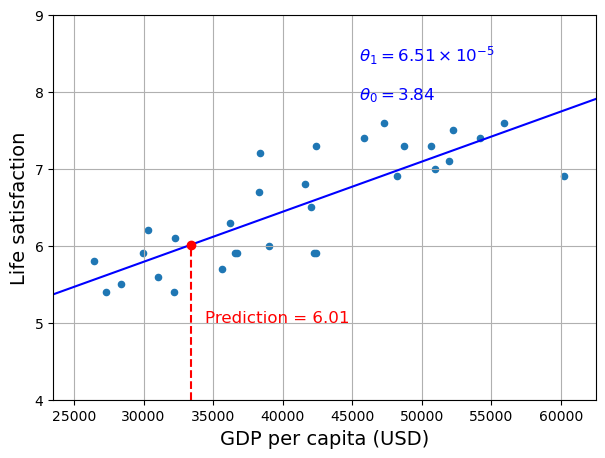

In [25]:
lifesat.plot(kind='scatter', figsize=(7, 5), grid=True,
                   x=gdppc_col, y=lifesat_col)

X_range = np.linspace(min_gdp, max_gdp, 1000)
plt.plot(X_range, theta_0 + theta_1 * X_range, "b")

plt.text(min_gdp + 22_000, max_life_sat - 1.1,
         fr"$\theta_0 = {theta_0:.2f}$", color="b")
plt.text(min_gdp + 22_000, max_life_sat - 0.6,
         fr"$\theta_1 = {theta_1 * 1e5:.2f} \times 10^{{-5}}$", color="b")

# Plot the prediction for Puerto Rico
plt.plot([puerto_rico_gdp_per_capita, puerto_rico_gdp_per_capita],
         [min_life_sat, puerto_rico_predicted_life_satisfaction], "r--")
plt.text(puerto_rico_gdp_per_capita + 1000, 5.0,
         fr"Prediction = {puerto_rico_predicted_life_satisfaction:.2f}",
         color="r")
plt.plot(puerto_rico_gdp_per_capita, puerto_rico_predicted_life_satisfaction,
         "ro")

plt.axis([min_gdp, max_gdp, min_life_sat, max_life_sat])

plt.show()

## 과대적합

이전 모델 학습에 사용된 훈련셋에서 제외된 국가들의 정보는 다음과 같다.

In [26]:
missing_data = lifesat_full[(lifesat_full[gdppc_col] < min_gdp) |
                            (lifesat_full[gdppc_col] > max_gdp)]
missing_data

,GDP per capita (USD),Life satisfaction
Country,,
South Africa,11466.189672,4.7
Colombia,13441.492952,6.3
Brazil,14063.982505,6.4
Mexico,17887.750736,6.5
Chile,23324.524751,6.5
Norway,63585.903514,7.6
Switzerland,68393.306004,7.5
Ireland,89688.956958,7.0
Luxembourg,110261.157353,6.9


### 새로운 선형 회귀 모델

제외된 9개 국가를 훈련셋에 포함 시킨 후 새로운 선형 회귀 모델을 훈련시킨다.

- 훈련셋과 타깃셋

In [27]:
Xfull = np.c_[lifesat_full[gdppc_col]]
yfull = np.c_[lifesat_full[lifesat_col]]

- 새로운 선형회귀 모델 훈련

In [28]:
from sklearn.linear_model import LinearRegression

oecd_linear_model_full = LinearRegression()
oecd_linear_model_full.fit(Xfull, yfull)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


아래 코드는 9개 국가를 제외 했을 때의 선형 회귀 모델(파랑 점선)과
포함시켰을 때의 선형 회귀 모델(검정 실선)의 그래프를 동시에 그린다.
두 모델이 상당히 다름을 확인할 수 있다.

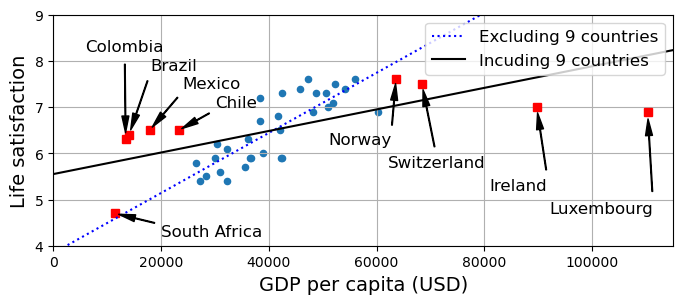

In [29]:
# 40개 국가 산점도
lifesat_full.plot(kind='scatter', figsize=(8, 3),
                        x=gdppc_col, y=lifesat_col, grid=True)

# 9개 국가 주석 추가
position_text_missing_countries = {
    "South Africa": (20_000, 4.2),
    "Colombia": (6_000, 8.2),
    "Brazil": (18_000, 7.8),
    "Mexico": (24_000, 7.4),
    "Chile": (30_000, 7.0),
    "Norway": (51_000, 6.2),
    "Switzerland": (62_000, 5.7),
    "Ireland": (81_000, 5.2),
    "Luxembourg": (92_000, 4.7),
}

for country, pos_text in position_text_missing_countries.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y),
                 xytext=pos_text, fontsize=12,
                 arrowprops=dict(facecolor='black', width=0.5,
                                 shrink=0.08, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

# 31개 국가 대상으로 학습된 선형 회귀 모델
X_range = np.linspace(0, 115_000, 1000)
plt.plot(X_range, theta_0 + theta_1 * X_range, "b:", label="Excluding 9 countries")

# 40개 국가 대상으로 학습된 선형 회귀 모델
theta_0_full, theta_1_full = oecd_linear_model_full.intercept_[0], oecd_linear_model_full.coef_[0][0]
plt.plot(X_range, theta_0_full + theta_1_full * X_range, "k", label="Incuding 9 countries")

plt.axis([0, 115_000, min_life_sat, max_life_sat])
plt.legend(loc='upper right')
plt.show()

### 선형 회귀 모델 규제

릿지(Ridge) 회귀 모델은 선형 회귀 모델의 과대적합을 완화시키는 규제가 추가된 선형 회귀 모델이며,
아래 코드는 9개 국가가 제외된 훈련셋을 활용하여 릿지 모뎅을 학습시킨다.

In [30]:
from sklearn.linear_model import Ridge

# 릿지 회귀 모델
ridge = Ridge(alpha=10**9.5)

# 훈련셋/타깃셋
X_sample = lifesat[[gdppc_col]]
y_sample = lifesat[[lifesat_col]]

# 릿지 회귀 모델 학습
ridge.fit(X_sample, y_sample)

,alpha,3162277660.1683793
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


아래 코드는 9개 국을 제외시키고 학습시켰음에도 불구하고
릿지 회귀 모델(파랑 파선)의 예측 성능이 9개 국을 포함시킨 선형 회귀 모델(검정 실선)과 큰 차이가 없음을 잘 보여준다.

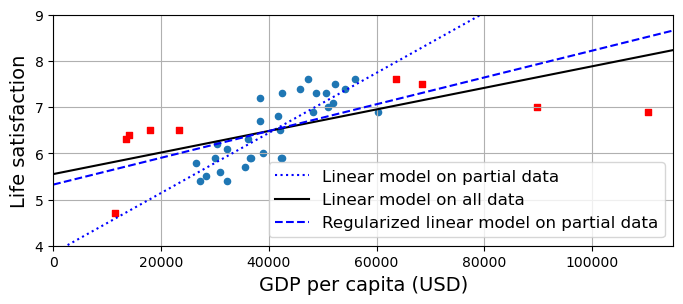

In [31]:
# 9개 국가가 제외된 산점도
lifesat.plot(kind='scatter', x=gdppc_col, y=lifesat_col, figsize=(8, 3))

# 9개 국가 산점도
missing_data.plot(kind='scatter', x=gdppc_col, y=lifesat_col,
                  marker="s", color="r", grid=True, ax=plt.gca())

X_range = np.linspace(0, 115_000, 1000)

# 31개 국가 대상으로 학습된 선형 회귀 모델
plt.plot(X_range, theta_0 + theta_1*X_range, "b:", label="Linear model on partial data")

# 40개 국가 대상으로 학습된 선형 회귀 모델
plt.plot(X_range, theta_0_full + theta_1_full * X_range, "k-", label="Linear model on all data")

# 릿지 회귀 모델
theta_0_ridge, theta_1_ridge = ridge.intercept_[0], ridge.coef_[0]
plt.plot(X_range, theta_0_ridge + theta_1_ridge * X_range, "b--",
         label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 115_000, min_life_sat, max_life_sat])

plt.show()

모델 규제에 대해서도 차찬 자세히 다룬다.

## OECD 삶의 만족도 데이터셋 생성 과정

`lifesat_full.csv` 데이터셋을 생성하는 과정을 상세히 다룬다.

### Load and prepare Life satisfaction data

To create `lifesat_full.csv`, I downloaded the Better Life Index (BLI) data from [OECD's website](http://stats.oecd.org/index.aspx?DataSetCode=BLI) (to get the Life Satisfaction for each country), and World Bank GDP per capita data from [OurWorldInData.org](https://ourworldindata.org/grapher/gdp-per-capita-worldbank). The BLI data is in `datasets/lifesat/oecd_bli.csv` (data from 2020), and the GDP per capita data is in `datasets/lifesat/gdp_per_capita.csv` (data up to 2020).

In [32]:
from pathlib import Path
import urllib.request

datapath = Path() / "datasets" / "lifesat"
datapath.mkdir(parents=True, exist_ok=True)

data_root = "https://github.com/codingalzi/code-workout-ml/raw/master/notebooks/datasets/"
for filename in ("oecd_bli.csv", "gdp_per_capita.csv"):
    if not (datapath / filename).is_file():
        print("Downloading", filename)
        url = data_root + "lifesat/" + filename
        urllib.request.urlretrieve(url, datapath / filename)

In [33]:
oecd_bli = pd.read_csv(datapath / "oecd_bli.csv")
gdp_per_capita = pd.read_csv(datapath / "gdp_per_capita.csv")

In [34]:
oecd_bli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LOCATION               2369 non-null   object 
 1   Country                2369 non-null   object 
 2   INDICATOR              2369 non-null   object 
 3   Indicator              2369 non-null   object 
 4   MEASURE                2369 non-null   object 
 5   Measure                2369 non-null   object 
 6   INEQUALITY             2369 non-null   object 
 7   Inequality             2369 non-null   object 
 8   Unit Code              2369 non-null   object 
 9   Unit                   2369 non-null   object 
 10  PowerCode Code         2369 non-null   int64  
 11  PowerCode              2369 non-null   object 
 12  Reference Period Code  0 non-null      float64
 13  Reference Period       0 non-null      float64
 14  Value                  2369 non-null   float64
 15  Flag

In [35]:
oecd_bli

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,5.40,NaN,NaN
1,AUT,Austria,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.50,NaN,NaN
2,BEL,Belgium,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.70,NaN,NaN
3,CAN,Canada,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,6.00,NaN,NaN
4,CZE,Czech Republic,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,LTU,Lithuania,WL_EWLH,Employees working very long hours,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,0.54,NaN,NaN
2365,COL,Colombia,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,Units,NaN,NaN,32.09,NaN,NaN
2366,LTU,Lithuania,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,Units,NaN,NaN,0.67,NaN,NaN
2367,COL,Colombia,WL_EWLH,Employees working very long hours,L,Value,WMN,Women,PC,Percentage,0,Units,NaN,NaN,19.37,NaN,NaN


In [36]:
gdp_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7110 entries, 0 to 7109
Data columns (total 4 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Entity                                               7110 non-null   object 
 1   Code                                                 5730 non-null   object 
 2   Year                                                 7110 non-null   int64  
 3   GDP per capita, PPP (constant 2017 international $)  7110 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 222.3+ KB


In [37]:
gdp_per_capita

,Entity,Code,Year,"GDP per capita, PPP (constant 2017 international $)"
0,Afghanistan,AFG,2002,1189.784668
1,Afghanistan,AFG,2003,1235.810063
2,Afghanistan,AFG,2004,1200.278013
3,Afghanistan,AFG,2005,1286.793659
4,Afghanistan,AFG,2006,1315.789117
...,...,...,...,...
7105,Zimbabwe,ZWE,2016,3173.610829
7106,Zimbabwe,ZWE,2017,3274.611198
7107,Zimbabwe,ZWE,2018,3341.665418
7108,Zimbabwe,ZWE,2019,3027.656038


Preprocess the GDP per capita data to keep only the year 2020:

In [38]:
gdp_year = 2020
gdppc_col = "GDP per capita (USD)"
lifesat_col = "Life satisfaction"

gdp_per_capita = gdp_per_capita[gdp_per_capita["Year"] == gdp_year]
gdp_per_capita = gdp_per_capita.drop(["Code", "Year"], axis=1)
gdp_per_capita.columns = ["Country", gdppc_col]
gdp_per_capita.set_index("Country", inplace=True)

In [39]:
gdp_per_capita

,GDP per capita (USD)
Country,
Afghanistan,1978.961579
Africa Eastern and Southern,3387.594670
Africa Western and Central,4003.158913
Albania,13295.410885
Algeria,10681.679297
...,...
Vanuatu,2762.791388
Vietnam,8200.331867
World,16194.040310


**푸에로토리코의 1인당 GDP**

In [40]:
puerto_rico_gdp_per_capita = gdp_per_capita[gdppc_col].loc["Puerto Rico"]
puerto_rico_gdp_per_capita

np.float64(33442.8315702748)

Preprocess the OECD BLI data to keep only the `Life satisfaction` column:

In [41]:
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

In [42]:
oecd_bli

Indicator,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,...,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0
Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,...,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0
Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,...,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3
Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,...,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2
Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,...,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3
Chile,16.0,9.4,65.0,9.72,63.0,47.9,4.2,NaN,100967.0,18.0,...,25879.0,85.0,1.2,57.0,1.3,443.0,NaN,47.0,71.0,17.5
Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,...,NaN,89.0,1.2,NaN,1.4,410.0,NaN,53.0,75.0,14.1
Czech Republic,20.0,0.7,94.0,5.65,74.0,72.3,0.5,21453.0,NaN,24.0,...,25372.0,91.0,1.4,60.0,1.6,491.0,NaN,61.0,87.0,17.9
Denmark,9.0,0.5,81.0,2.34,74.0,83.5,0.6,29606.0,118637.0,23.0,...,51466.0,95.0,1.9,71.0,2.0,504.0,15.87,86.0,95.0,19.5


In [43]:
oecd_bli_list = oecd_bli.index.tolist()
gdp_per_capita_list = gdp_per_capita.index.tolist()

**두 데이터셋의 인덱스로 사용된 국가명 차이 확인**

In [44]:
set(oecd_bli_list) - set(gdp_per_capita_list)

{'Czech Republic', 'Korea', 'OECD - Total', 'Slovak Republic'}

- `'OECD - Total'`은 국가가 아님. 삭제 대상

In [45]:
oecd_bli.drop(index=['OECD - Total'], inplace=True)

- 체코, 대한민국, 슬로바키아 세 나라의 국가명이 두 데이터셋에서 다르게 불림. 이름 통일 필요.
    - `oecd_bli.csv` 파일: Czech Repulic, Korea, Slovak Republic
    - `gdp_per_capita.csv` 파일: Czechia, South Korea, Slovakia

In [46]:
names_to_change = {'Czech Republic': 'Czechia',
                   'Korea': 'South Korea',
                   'Slovak Republic': 'Slovakia'}

In [47]:
oecd_bli.rename(index=names_to_change, inplace=True)

잘 수정되었음을 확인할 수 있다.

In [48]:
oecd_bli_list = oecd_bli.index.tolist()
gdp_per_capita_list = gdp_per_capita.index.tolist()

In [49]:
set(oecd_bli_list) - set(gdp_per_capita_list)

set()

Now let's merge the life satisfaction data and the GDP per capita data, keeping only the GDP per capita and Life satisfaction columns:

In [50]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                              left_index=True, right_index=True)
full_country_stats.sort_values(by=gdppc_col, inplace=True)
full_country_stats = full_country_stats[[gdppc_col, lifesat_col]]

In [51]:
full_country_stats

,GDP per capita (USD),Life satisfaction
Country,,
South Africa,11466.189672,4.7
Colombia,13441.492952,6.3
Brazil,14063.982505,6.4
Mexico,17887.750736,6.5
Chile,23324.524751,6.5
Russia,26456.387938,5.8
Greece,27287.083401,5.4
Turkey,28384.987785,5.5
Latvia,29932.493910,5.9


To illustrate the risk of overfitting, I use only part of the data in most figures (all countries with a GDP per capita between `min_gdp` and `max_gdp`). Later in the chapter I reveal the missing countries, and show that they don't follow the same linear trend at all.

In [52]:
min_gdp = 23_500
max_gdp = 62_500

country_stats = full_country_stats[(full_country_stats[gdppc_col] >= min_gdp) &
                                   (full_country_stats[gdppc_col] <= max_gdp)]
country_stats

,GDP per capita (USD),Life satisfaction
Country,,
Russia,26456.387938,5.8
Greece,27287.083401,5.4
Turkey,28384.987785,5.5
Latvia,29932.493910,5.9
Slovakia,30330.042887,6.2
Hungary,31007.768407,5.6
Portugal,32181.154537,5.4
Poland,32238.157259,6.1
Estonia,35638.421351,5.7


In [53]:
country_stats.to_csv(datapath / "lifesat.csv")
full_country_stats.to_csv(datapath / "lifesat_full.csv")